<a href="https://colab.research.google.com/github/abhaskumarsinha/Corpus2GPT/blob/main/guides/LinePairDatasetExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emergent Abilities of Transformer based Autoregressive Models

**Created By:** ABHAS KUMAR SINHA

**Date of Creation:** 17-09-2024

**Abstract:** Transformer based autoregressive models are well-known for their **emergent abilities** such as *0-shot learning*, *in-context learning* or *generalization*. This notebook contains a tutorial guide on using **Corpus2GPT** framework demonstrating *generalization* abilities of a *transformer-based GPT model*: given a function $f$, defined over some space $\mathcal X$, the points $\{(x_1, f(x_1)), (x_2, f(x_2)), \dots, (x_n, f(x_n)\}, \forall x_i \in \mathcal X$, the LLM $LLM_\theta(,)$ is able to learn function $f(x)$, with parameters $\theta$, such that there exists $\theta^*$ and $n$, so that
$$ ||LLM_\theta (x') - f(x') ||_l \leq \epsilon \tag{*}$$ for any $x'\in \mathcal X$, and any $\epsilon$.
This ability of LLMs to act like an *universal function approximator* is called *generalization ability* [1, 2].

In this tutorial, we demonstrate how to train an LLM to encode sentences (each containing 4 words) from one *hypothetical* language to another, both *synthetically* generated. Out of a total of 17,000 possible encodings, the Corpus2GPT Model is trained on just 1000 sequences and successfully generalizes to approximately 50-60% of the total possible encodings.


## Cloning *Corpus2GPT* and importing important libraries

<br>
<br>

![image](https://private-user-images.githubusercontent.com/31654395/326205623-80181c4f-e898-4345-9768-b1021776ebda.jpg?jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3MjY1OTE2ODUsIm5iZiI6MTcyNjU5MTM4NSwicGF0aCI6Ii8zMTY1NDM5NS8zMjYyMDU2MjMtODAxODFjNGYtZTg5OC00MzQ1LTk3NjgtYjEwMjE3NzZlYmRhLmpwZz9YLUFtei1BbGdvcml0aG09QVdTNC1ITUFDLVNIQTI1NiZYLUFtei1DcmVkZW50aWFsPUFLSUFWQ09EWUxTQTUzUFFLNFpBJTJGMjAyNDA5MTclMkZ1cy1lYXN0LTElMkZzMyUyRmF3czRfcmVxdWVzdCZYLUFtei1EYXRlPTIwMjQwOTE3VDE2NDMwNVomWC1BbXotRXhwaXJlcz0zMDAmWC1BbXotU2lnbmF0dXJlPWM5ZTFkZTk0MGI0MDgyOTVlNjRjOTg4MTJjZmI3OGUyODRlZGJlNzJhYzk0NjY0MWI2YTQyOGUyMTFiNmZlODUmWC1BbXotU2lnbmVkSGVhZGVycz1ob3N0JmFjdG9yX2lkPTAma2V5X2lkPTAmcmVwb19pZD0wIn0.4lw9pCYMfozpngVyHW76srcq_sE710cYT11MUNVCCi0)
###### This example has been provided by Official Corpus2GPT package.


In [1]:
!git clone https://www.github.com/abhaskumarsinha/Corpus2GPT.git

Cloning into 'Corpus2GPT'...
remote: Enumerating objects: 1025, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 1025 (delta 14), reused 3 (delta 3), pack-reused 994 (from 1)
Receiving objects: 100% (1025/1025), 1.76 MiB | 8.19 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [2]:
from Corpus2GPT.utils import LanguagePairDataset as LPD
from Corpus2GPT.tokenizer import SPM_Tokenizer
from Corpus2GPT.models import build_GPT

from Corpus2GPT.inference import Generative_inference

import numpy as np
import keras

## Configuration of our settings

Here are the initial configuration of our entire Colab Notebook. The following decide the nature of our generated *synthetic* language, *dataset*, *tokenizer settings*, *GPT* config, and *trainer settings*:

- `total_vocabs`, `total_char` - total vocabulary of each language (there are two languages: *given language* and *target language*).
- `sentence_len`, `total_instances`, `instance_split`, `sentence split` - length of the sentence, total translation sentences in our dataset of **each language**, token to separate sentences of two languages and token to split each instance from other of 1000 instances.
- `tokenizer_vocab_settings` - Each word is one char long. Two languages have 13 + 13 = 26 tokens in all. Space, Start, End, `instance_split` and `sentence_split` occupy total 32 tokens in total.
- `gpt_input_length`, `embedding_dim`, `num_decoder`, 'dropout_rate', `num_heads`, `head_dims`, `fc_dim_factor`, `epsilon` - Input token size of GPT model, embedding vector of each token, number of stacked decoder, dropout_rate during training, number of heads, head dimensions, FCN dimension (multiplicative factor to `embedding_dim`), epsilon (for Normalization layer, [See this](https://keras.io/api/layers/normalization_layers/batch_normalization/#:~:text=%3D0.99%2C-,epsilon%3D0.001,-%2C%0A%20%20%20%20center%3D))
- `epochs`, `batch_size` - For training epochs and batch size of the sample being trained


In [3]:
total_vocabs = 13
total_chars = 1

sentence_len = 4
total_instances = 1000
instance_split = '|'
sentence_split = '.'

tokenizer_vocab_size = 32

gpt_input_len = 32
embedding_dim = 200
num_decoder = 1
dropout_rate = 0
num_heads = 20
head_dims = 10
fc_dim_factor = 5
epsilon = 1e-14

epochs = 200
batch_size = 128

## Generate Synthetic Dataset and Create SPM Tokenizer

**May take a few minutes...**

In [4]:
dataset = LPD()

dataset.create_vocabs(total_vocabs, total_chars)
dataset.create_vocabs(total_vocabs, total_chars)

lang_map, reverse_map = dataset.create_map(0, 1)
dataset.write_dataset_to_file(lang_map, reverse_map, sentence_len, total_instances, './test_translation_dataset.txt', append=False, instance_split=instance_split, sentence_split=sentence_split)

In [5]:
SPM_Tokenizer(vocab_size = tokenizer_vocab_size, corpus='./test_translation_dataset.txt')
tokenizer = SPM_Tokenizer(vocab_model_file='tokenizer_.model', input_size = gpt_input_len+1)

Success!


## Create a GPT Model

Note: `flops` *contain rough number of floating-point operations done by the GPT Model in a single **forward pass**.*

**May take a few seconds...**

In [6]:
GPT, flops = build_GPT(gpt_input_len, tokenizer_vocab_size, embedding_dim, num_decoder, dropout_rate, num_heads, head_dims, fc_dim_factor, epsilon)

In [7]:
GPT.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ token_and_position_embedding         │ (None, 32, 200)             │          12,800 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ (None, 32, 200)             │         562,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32, 33)              │           6,633 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 582,233 (2.22 MB)

 Trainable params: 582,233 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

## Load the dataset we have written earlier to the file and tokenizer and vectorize each instance respectively.
- `inference` is used to load each inference instance.
- `callback` that measured number of correct translation done by the GPT model after each epoch by testing it on a random generated sentence by `dataset.evaluate_model_accuracy` - that returns a number from $0$ to $1$ of total fraction of words being correctly translated. A total of average of $5$-such translation is shown and stored in the python-list `test_history`.

In [8]:
for (X, Y) in tokenizer.load_dataset(['./test_translation_dataset.txt']):
    X, Y = np.array(X), np.array(Y)

In [9]:
inference = Generative_inference(GPT, tokenizer, input_len=gpt_input_len)

class GetTranslationAccuracy(keras.callbacks.Callback):
    def __init__(self, num_test = 5):
        self.num_test = num_test
        self.test_history = []

    def on_epoch_end(self, epoch, logs=None):
        score = 0
        for i in range(self.num_test):
            score += dataset.evaluate_model_accuracy(lang_map, reverse_map, sentence_len, inference, 8, 7)/self.num_test

        self.test_history.append(score)
        print('\n\nTotal Hits: ' + str(score) + '\n\n')

callback = GetTranslationAccuracy(5)

## Training + Callback Testing

Lessssssssssssss Goooooooooooooooooooooo!!

In [10]:
history = GPT.fit(X, Y, batch_size = batch_size, epochs = epochs, callbacks=[callback])

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - loss: 3.2559

Total Hits: 0.05


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 3.1457  
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.7946   

Total Hits: 0.05


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 1.7921
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.6900

Total Hits: 0.0


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.6883
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.6279

Total Hits: 0.0


5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 1.6269
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - loss: 1.6154

Total Hits: 0.0


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 1.6150   
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.6017

Total Hits: 0.05


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 1.6015
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - loss: 1.5889

Total Hits: 0.0


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 1.5886   
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94

## Plot Section


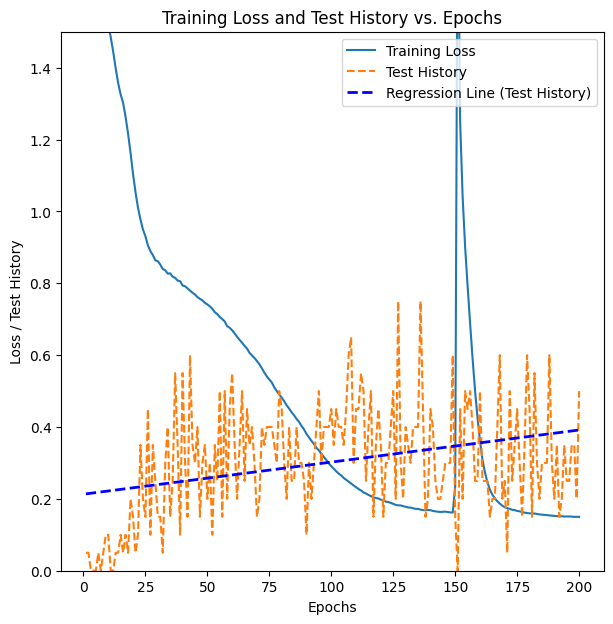

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
test_history = callback.test_history

# Create a figure with a size of 5x5 inches
plt.figure(figsize=(7, 7))

# Plot the cross-entropy loss vs. epochs
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')

# Plot the callback test history
plt.plot(range(1, len(test_history) + 1), test_history, label='Test History', linestyle='--')

# Perform linear regression on test_history
epochs = np.arange(1, len(test_history) + 1)
slope, intercept = np.polyfit(epochs, test_history, 1)  # degree 1 for linear fit

# Calculate the regression line
regression_line = slope * epochs + intercept

# Plot the regression line as a dotted blue line
plt.plot(epochs, regression_line, 'b--', label='Regression Line (Test History)', linewidth=2)

# Labeling the plot
plt.title('Training Loss and Test History vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss / Test History')
plt.ylim(0, 1.5)

# Show the plot legend
plt.legend()

# Display the plot
plt.show()

## Wanna Test your manual sentences here?

Replace the below `"|"` with anything you like. `"h e l l o |"`.



In [13]:
inference.generate("|", generate_limit=15,  k_value=1)

' ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  | |  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ '

# References
1. Yun, Chulhee, et al. "Are transformers universal approximators of sequence-to-sequence functions?." arXiv preprint arXiv:1912.10077 (2019).
2. Jiang, Hui. "A latent space theory for emergent abilities in large language models." arXiv preprint arXiv:2304.09960 (2023).
3.Radford, Alec, et al. "Language models are unsupervised multitask learners." OpenAI blog 1.8 (2019): 9.
4. Vaswani, A. "Attention is all you need." Advances in Neural Information Processing Systems (2017).